In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Conv2D, concatenate, BatchNormalization, DepthwiseConv2D
from tensorflow.keras.layers import Lambda, Reshape, Layer, Activation, Add, Multiply
from tensorflow.keras import layers
from math import ceil
import numpy as np

In [ ]:
class AE(Model):
  def __init__(self):
    super(AE, self).__init__()
    self.code = Dense(8,activation = 'relu')
  def build(self, input_shape):
    self.dense1 = Dense(input_shape[-1], activation = 'relu')
    self.dense2 = Dense(input_shape[-1], activation = 'relu')
  def call(self, inputs):    
    d1 = self.dense1(inputs)
    code = self.code(d1)
    d2 = self.dense2(code)    
    return d2

In [ ]:
class CBAM(Model):
  def __init__(self):
    super(CBAM, self).__init__()          
    self.relu = Activation('relu') 
    self.AvgPool = AveragePooling2D(pool_size=(2, 2),strides=(1, 1), padding='same')
    self.MaxPool = MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='same')    
    self.conv = Conv2D(1, (7, 7), strides=(1, 1), padding='same', activation='sigmoid')
    self.AE = AE()

  def call(self, inputs):
    #for channel attention    
    GAP = GlobalAveragePooling2D()(inputs)    
    GMP = GlobalMaxPooling2D()(inputs)    
    AE1 = self.AE(GAP)
    AE2 = self.AE(GMP)
    add = Add()([AE1, AE2])
    channel_attention = self.relu(add)
    multiply1 = Multiply()([inputs, channel_attention])
    #for spatial attention
    GAP_f = self.AvgPool(multiply1)
    GMP_f = self.MaxPool(multiply1)
    concat = concatenate([GAP_f, GMP_f])   
    spatial_attention = self.conv(concat)
    output = Multiply()([multiply1, spatial_attention])    
    return output

In [ ]:
class GhostModule(Model):
  def __init__(self, out, ratio, dwkernel):
    super(GhostModule, self).__init__()
    self.ratio = ratio
    self.out = out
    self.conv_out_channel = ceil(self.out * 1.0 / ratio)    
    self.conv = Conv2D(int(self.conv_out_channel), (3, 3),
                        strides=(1, 1), padding='same', activation='relu')
    self.depthconv = DepthwiseConv2D(dwkernel, 1, padding='same',
                        depth_multiplier=ratio-1, activation='relu')
    self.BN = BatchNormalization()

  def call(self, inputs):
    x = self.conv(inputs)
    if self.ratio == 1:
      return x
    dw = self.depthconv(x)
    dw = dw[:, :, :, :int(self.out - self.conv_out_channel)]
    output = self.BN(concatenate([x, dw]))
    return output

In [ ]:
class GhostVGG16(Model):
  def __init__(self):
    super(GhostVGG16, self).__init__()
    self.outs = [64, 64, 128, 128, 256, 256, 256, 512, 512, 512, 512, 512, 512]       
    self.ratio = [2]*13
    self.dwkernek = [3]*13
    self.flatten = Flatten()
    self.MaxPooling = MaxPooling2D((2,2))
    self.dense1 = Dense(4096, activation='relu')
    self.dense2 = Dense(4096, activation='relu')
    self.dense3 = Dense(10, activation='softmax')    
    self.dropout = Dropout(0.5)
    for i, args in enumerate(zip(self.outs, self.ratio, self.dwkernek)):
      setattr(self, f"Gmodule{i+1}", GhostModule(*args)) 
    for i in range(3):
      setattr(self, f"CBAM{i+1}", CBAM())
    
  def call(self, inputs):        
    #2 x 64    
    #x = self.G_Module0(inputs)
    x = getattr(self, f"Gmodule1")(inputs) 
    x = getattr(self, f"CBAM1")(x) 
    x = getattr(self, f"Gmodule2")(x)
    x = self.MaxPooling(x)
    #2 x 128
    x = getattr(self, f"Gmodule3")(x) 
    x = getattr(self, f"CBAM2")(x) 
    x = getattr(self, f"Gmodule4")(x)
    x = self.MaxPooling(x)
    #3 x 256
    x = getattr(self, f"Gmodule5")(x) 
    x = getattr(self, f"Gmodule6")(x) 
    x = getattr(self, f"CBAM3")(x)    
    x = getattr(self, f"Gmodule7")(x) 
    x = self.MaxPooling(x)
    #3 x 512
    x = getattr(self, f"Gmodule8")(x) 
    x = getattr(self, f"Gmodule9")(x)
    x = getattr(self, f"Gmodule10")(x)
    x = self.MaxPooling(x)
    #3 x 512
    x = getattr(self, f"Gmodule11")(x)  
    x = getattr(self, f"Gmodule12")(x)
    x = getattr(self, f"Gmodule13")(x)
    x = self.MaxPooling(x)  
    #flat  
    flat = self.flatten(x)
    x = self.dense1(flat)
    x = self.dropout(x)
    x = self.dense2(x)
    x = self.dropout(x)
    #dense 10
    output = self.dense3(x)
    return output

In [ ]:
def scheduler(epoch):
  learning_rate = 0.001
  if epoch < epoch_num * 0.4:
    return learning_rate
  if epoch < epoch_num * 0.8:
    return learning_rate * 0.1
  return learning_rate * 0.01

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [ ]:
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [ ]:
tf.shape(x_train)

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([50000,    32,    32,     3], dtype=int32)>

In [ ]:
IMAGE_SIZE = 32
batch_size = 64
epoch_num = 50
AUTO = tf.data.AUTOTUNE

In [ ]:
simple_aug = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ]
)

# Now, map the augmentation pipeline to our training dataset
train_ds_simple = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(64 * 100)
    .batch(64)
    .map(lambda x, y: (simple_aug(x), y), num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

test_ds_simple = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .shuffle(64 * 100)
    .batch(64)
    .map(lambda x, y: (simple_aug(x), y), num_parallel_calls=AUTO)
    .prefetch(AUTO)
) 

In [ ]:
#change_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.09, nesterov=True)
#adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
model = GhostVGG16()
model.build(input_shape = (1, 32, 32, 3))
model.summary()

Model: "ghost_vg_g16_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          multiple                  0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling multiple                  0         
_________________________________________________________________
dense_30 (Dense)             multiple                  2101248   
_________________________________________________________________
dense_31 (Dense)             multiple                  16781312  
_________________________________________________________________
dense_32 (Dense)             multiple                  40970     
_________________________________________________________________
dropout_4 (Dropout)          multiple                  0         
_________________________________________________________________
ghost_module_52 (GhostModule multiple               

!nvidia-smi

In [ ]:
checkpoint = tf.train.Checkpoint(myModel=model)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history = model.fit(train_ds_simple,
          batch_size=batch_size,
          epochs=100,          
          validation_data=test_ds_simple)

Epoch 1/100
782/782 [==============================] - 40s 46ms/step - loss: 2.3756 - accuracy: 0.1358 - val_loss: 2.1971 - val_accuracy: 0.1779
Epoch 2/100
782/782 [==============================] - 35s 45ms/step - loss: 2.1568 - accuracy: 0.2000 - val_loss: 2.0049 - val_accuracy: 0.2689
Epoch 3/100
782/782 [==============================] - 35s 45ms/step - loss: 1.9992 - accuracy: 0.2458 - val_loss: 1.8698 - val_accuracy: 0.3045
Epoch 4/100
782/782 [==============================] - 35s 45ms/step - loss: 1.8952 - accuracy: 0.2818 - val_loss: 1.7851 - val_accuracy: 0.3232
Epoch 5/100
782/782 [==============================] - 35s 45ms/step - loss: 1.7954 - accuracy: 0.3273 - val_loss: 1.7335 - val_accuracy: 0.3519
Epoch 6/100
782/782 [==============================] - 35s 45ms/step - loss: 1.7015 - accuracy: 0.3682 - val_loss: 1.6227 - val_accuracy: 0.3988
Epoch 7/100
782/782 [==============================] - 35s 45ms/step - loss: 1.6266 - accuracy: 0.3994 - val_loss: 1.6838 - val_ac

In [ ]:
model.metrics_names

['loss', 'accuracy']

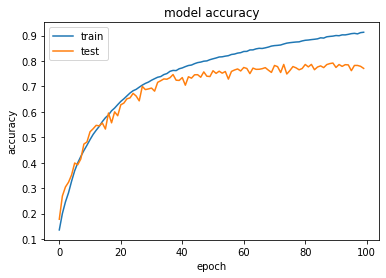

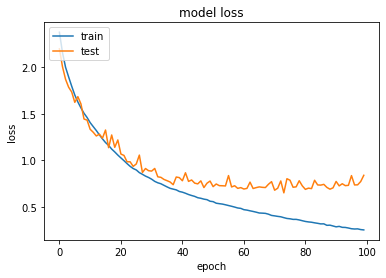

In [ ]:
# summarize history for accuracy
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
checkpoint.save('/content/drive/MyDrive/Colab Notebooks/2021/paper/CBAM_GhostNet/weightmodel.ckpt')

'/content/drive/MyDrive/Colab Notebooks/2021/paper/CBAM_GhostNet/weightmodel.ckpt-1'